## Setup

In [ ]:
%pip install 'vanna[qdrant,openai,mysql]'

In [3]:
from vanna.openai import OpenAI_Chat
from vanna.qdrant import Qdrant_VectorStore
from qdrant_client import QdrantClient
from openai import OpenAI


In [8]:
class MyVanna(Qdrant_VectorStore, OpenAI_Chat):
    def __init__(self, client=None, config=None):
        # 分别初始化两个父类
        Qdrant_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self,client=client,config=config)

# 配置信息
api_key = "sk-pH3LeinCFI54OlJI238c014eE8D64a0f882cA285375d72A3"
base_url = "https://api.juheai.top/v1"
model_name = "gpt-4.1-nano"

# 初始化Qdrant客户端
config = {
	'client': QdrantClient(host="112.124.5.73",port=2280),
  'model': model_name
}

# 创建Vanna实例
vn = MyVanna(
    client=OpenAI(api_key=api_key,base_url=base_url),
    config=config
)


In [9]:
vn.connect_to_mysql(host='rm-bp1x9482wcuc92dfe6o.mysql.rds.aliyuncs.com', dbname='cocoteam-cloud', user='cocoteam_read', password='rQqSJlZRi9', port=3306)

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [ ]:

# The information schema query may need some tweaking depending on your database. This is a good starting point.
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")

# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

# If you like the plan, then uncomment this and run it to train
# vn.train(plan=plan)



In [21]:

# The following are methods for adding training data. Make sure you modify the examples to match your database.

# DDL statements are powerful because they specify table names, colume names, types, and potentially relationships
# vn.train(ddl="""
#     CREATE TABLE `departments` (
#     `department_id` int NOT NULL AUTO_INCREMENT COMMENT '部门ID，主键',
#     `department_name` varchar(50) COLLATE utf8mb4_general_ci NOT NULL COMMENT '部门名称',
#     `location` varchar(100) COLLATE utf8mb4_general_ci DEFAULT NULL COMMENT '部门办公地点',
#     `description` text COLLATE utf8mb4_general_ci COMMENT '部门描述',
#     `created_at` timestamp NULL DEFAULT CURRENT_TIMESTAMP COMMENT '创建时间',
#     PRIMARY KEY (`department_id`)
#   ) ENGINE=InnoDB AUTO_INCREMENT=11 DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_general_ci COMMENT='公司部门信息表';

# """)

# Sometimes you may want to add documentation about your business terminology or definitions.
# vn.train(documentation="订单状态：0代表未开始，1代表进行中，2代表已完成，3代表已取消")

# You can also add SQL queries to your training data. This is useful if you have some queries already laying around. You can just copy and paste those from your editor to begin generating new SQL.
vn.train(question="本月应收金额",sql="SELECT SUM(r.f_ar_amount) AS total_receivable_amount FROM coco_sales_salesorder_receivable r JOIN coco_sales_salesorder_header h ON r.f_so_id = h.f_id WHERE h.f_delete_mark = 0 AND h.f_status != 3 AND r.f_delete_mark = 0 AND MONTH(r.f_ar_time) = MONTH(CURDATE()) AND YEAR(r.f_ar_time) = YEAR(CURDATE());")
# vn.train(question="最畅销的商品是什么？",sql="SELECT p.product_name, SUM(o.quantity) AS total_sold FROM products p JOIN orders o ON p.product_id = o.product_id GROUP BY p.product_id ORDER BY total_sold DESC LIMIT 1;")
# vn.train(question="按类别统计所有商品的库存总量。",sql="SELECT category, SUM(stock_quantity) AS total_stock FROM products GROUP BY category;")
# vn.train(question="显示目前上架的所有商品及其价格。",sql="SELECT product_name, price FROM products WHERE is_active = 1;")
# vn.train(question="过去一个月内销售额最高的商品是哪一个？",sql="SELECT p.product_name, SUM(p.price * o.quantity) AS total_sales FROM products p JOIN orders o ON p.product_id = o.product_id WHERE o.order_date BETWEEN DATE_SUB(CURDATE(), INTERVAL 1 MONTH) AND CURDATE() GROUP BY p.product_id ORDER BY total_sales DESC LIMIT 1;")
# vn.train(question="哪些用户在过去的一年内没有进行任何购买？",sql="SELECT u.username FROM users u LEFT JOIN orders o ON u.user_id = o.user_id AND o.order_date >= DATE_SUB(CURDATE(), INTERVAL 1 YEAR) WHERE o.order_id IS NULL;")



'7869c78f-75ad-54f9-90ff-d0d1c860486f-sql'

In [7]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,08662319-184c-510d-9477-114ec71fb61d-sql,最近一周新增的线索数量,SELECT COUNT(*) AS recent_week_leads FROM coco...,sql
1,0890ef88-61ab-5366-a3c4-911a1bbca976-sql,按线索来源统计数量,SELECT CASE salesleads_source WHEN 0 THEN '客户推...,sql
2,0d413456-68e6-5cf9-98ee-8b19d538dc07-sql,哪些线索的下次跟进时间在今天之内？,"SELECT s.f_id, s.salesleads_name, u.f_real_nam...",sql
3,18d0bab7-352a-5717-818f-ea13bea6f1c8-sql,哪些线索没有转换为商机？,"SELECT s.f_id, s.salesleads_name, u.f_real_nam...",sql
4,52fb7522-5965-59d8-877e-32271b499182-sql,跟进中的线索有哪些，按负责人统计,"SELECT u.f_real_name AS owner_name, COUNT(*) A...",sql
5,93cb4379-84fd-509b-bc6a-4f8c9003383c-sql,按线索来源统计数量,"SELECT salesleads_source, COUNT(*) AS count FR...",sql
6,9ce027fb-8417-5aef-b819-fefb736c5124-sql,跟进记录最多的前5条线索,"SELECT r.f_salesleads_id, s.salesleads_name, C...",sql
7,ab853aad-8df6-54c9-b7fc-088c90f1c1fa-sql,每个负责人的线索数量是多少？,"SELECT u.f_real_name AS owner_name, COUNT(*) A...",sql
8,b10e03ce-4904-50e2-9b4c-b1e6e6c9f802-sql,哪些线索已经超过了下一个跟进时间但还未跟进？,"SELECT s.f_id, s.salesleads_name, u.f_real_nam...",sql
9,b40eacb1-6d76-5fe9-9737-30fbe4085df9-sql,哪些线索已经被取消？并列出取消原因,"SELECT s.f_id, s.salesleads_name, u.f_real_nam...",sql


In [ ]:
# You can remove training data if there's obsolete/incorrect information.
vn.remove_training_data(id='1-ddl')


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

SQL Prompt: [{'role': 'system', 'content': 'You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE `coco_sales_salesorder_header` (\n  `f_id` varchar(32) NOT NULL COMMENT \'主键ID\',\n  `f_order_no` varchar(15) NOT NULL COMMENT \'订单号\',\n  `f_status` varchar(2) DEFAULT NULL COMMENT \'订单状态：0未开始，1进行中，2已完成，3已取消\',\n  `f_order_time` datetime DEFAULT NULL COMMENT \'订单日期：2024-06-05 00:00:00\',\n  `f_order_type` varchar(50) DEFAULT NULL COMMENT \'订单类型：\tR(自主研发项目),P(销售采购项目),H(人力外包项目),G(通用开发项目),F(智能工厂项目),值示例：R\',\n  `f_order_source` varchar(50) DEFAULT NULL COMMENT \'订单来源：1(人工订单),2(商机转化),3(其他)\',\n  `f_source_desc` varchar(500) DEFAULT NULL COMMENT \'来源说明\',\n  `f_customer_name` varchar(100) DEFAULT NULL COMMENT \'客户名称\',\n  `f_customer_address` varchar(255) DEFAULT NULL COMMENT \'客户地址\',\n  `f_cntact_person` varchar(50) DEFAULT 

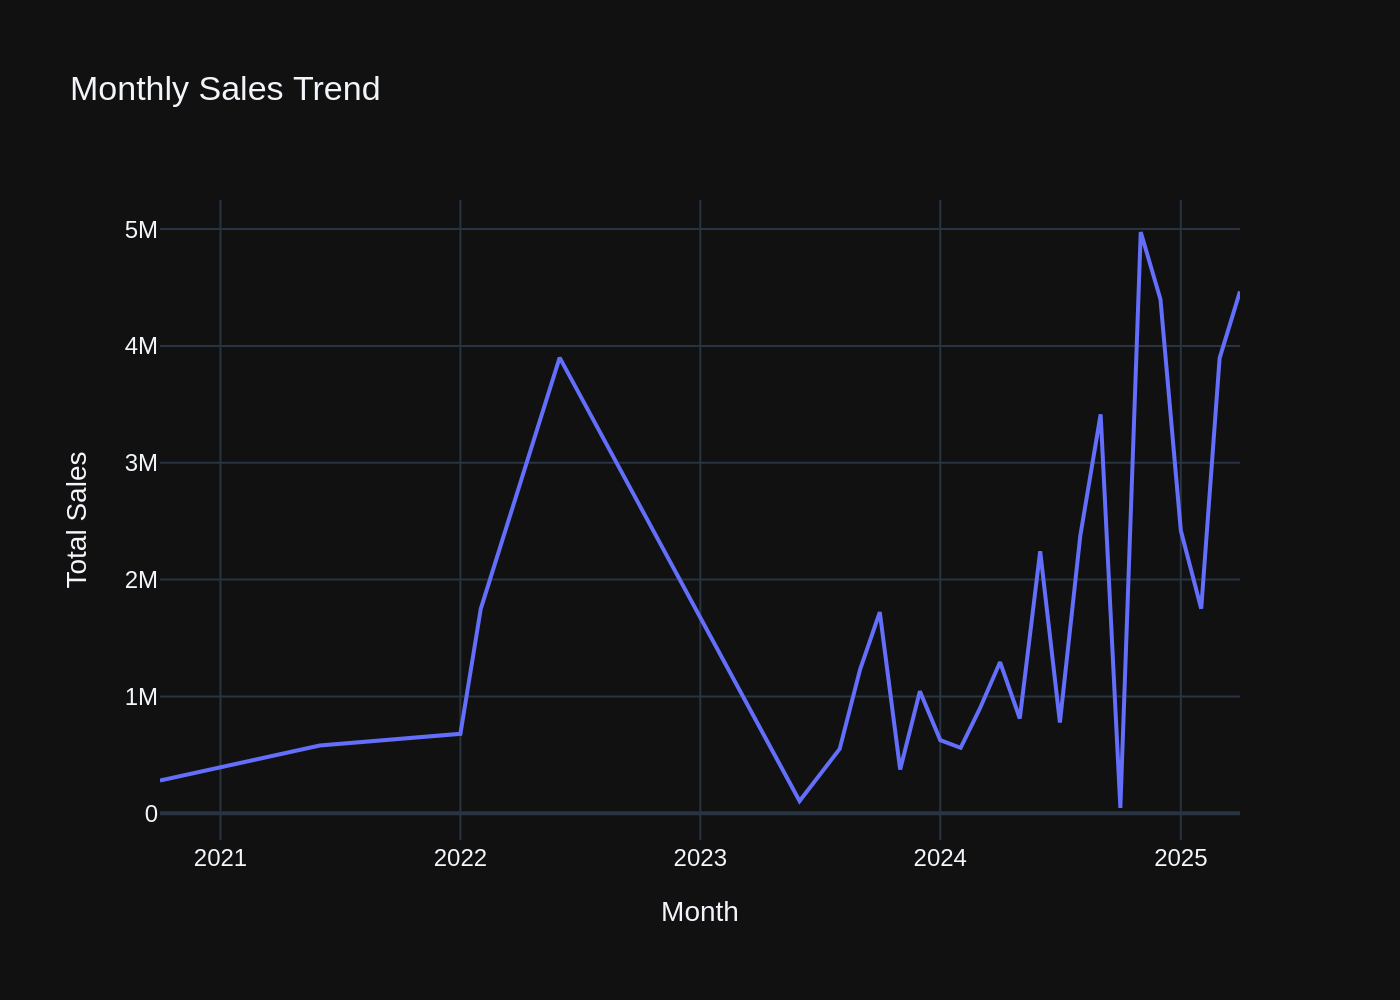

("SELECT DATE_FORMAT(f_order_time, '%Y-%m') AS month, SUM(f_so_amount) AS total_sales\nFROM coco_sales_salesorder_header\nWHERE f_delete_mark = 0 AND f_status != 3\nGROUP BY month\nORDER BY month;",
       month  total_sales
 0   2020-10    280000.00
 1   2021-06    580000.00
 2   2022-01    680000.00
 3   2022-02   1750000.00
 4   2022-06   3900000.00
 5   2023-06    104400.00
 6   2023-08    550000.00
 7   2023-09   1229778.22
 8   2023-10   1721500.00
 9   2023-11    375000.00
 10  2023-12   1043475.00
 11  2024-01    625840.00
 12  2024-02    559680.00
 13  2024-03    892600.00
 14  2024-04   1294000.00
 15  2024-05    810550.00
 16  2024-06   2241735.00
 17  2024-07    775850.00
 18  2024-08   2373550.00
 19  2024-09   3413977.50
 20  2024-10     44650.00
 21  2024-11   4975306.36
 22  2024-12   4398497.25
 23  2025-01   2419824.36
 24  2025-02   1751087.44
 25  2025-03   3895919.07
 26  2025-04   4466501.17,
 Figure({
     'data': [{'hovertemplate': 'month=%{x}<br>total_sales=%{y

In [29]:
vn.ask(question="分析下销售额每个月的趋势",allow_llm_to_see_data=True)

In [28]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn,allow_llm_to_see_data=True,logo="https://cocoteam.com/resource/img/logo@2x.png",title="芯港AI报表测试",subtitle="text2sql在线测试")
app.run()

Google Colab doesn't support running websocket servers. Disabling debug mode.
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

Your app is running at:
https://8084-m-s-3ar3m3lw26l2d-c.us-west1-0.prod.colab.dev
 * Serving Flask app 'vanna.flask'
 * Debug mode: off
SQL Prompt: [{'role': 'system', 'content': 'You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE `coco_sales_salesorder_header` (\n  `f_id` varchar(32) NOT NULL COMMENT \'主键ID\',\n  `f_order_no` varchar(15) NOT NULL COMMENT \'订单号\',\n  `f_status` varchar(2) DEFAULT NULL COMMENT \'订单状态：0未开始，1进行中，2已完成，3已取消\',\n  `f_order_time` datetime DEFAULT NULL COMMENT \'订单日期：2024-06-05 00:00:00\',\n  `f_order_type` varchar(50) DEFAULT NULL COMMENT \'订单类型：\tR(自主研发项目),P(销售采购项目),H(人力外包项目),G(通用开发项目),F(智能工厂项目),值示例：R\',\n  `f_order_source` varchar(50) DEFAULT NULL COMMENT \'订单来源：1(人工订单),2(商机转化),3(其他)\',\n  `f_source_desc` varchar(500) DEFAULT NULL COMMENT \'来源说明\',\n  `f_customer_name` varchar(100) DEF